In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import randrange

In [5]:
#function to calculate prior
def prior_function(df, Y):
    classes = sorted(list(df[Y].unique()))
    prior = []
    for i in classes:
        prior.append(len(df[df[Y] == i])/len(df))
    return prior

In [6]:
#function to calculate likelihood
def likelihood_function(df, feat_name, feat_value, Y, label):
    feat = list(df.columns)
    df = df[df[Y] == label]
    
    #mean
    mean = df[feat_name].mean()
    #variance
    std = df[feat_name].std()
    
    #based on Optimality of the Linear Classifier equation
    #Gaussian density function
    likelihood = (1/(np.sqrt(2*np.pi)*std))*np.exp(-((feat_value-mean)**2/(2*std**2)))
    return likelihood

In [54]:
#calculate the prediction values and posteriori probability based on naive bayes algorithm
#the motivation of the method used in this assignment
#the data are continuous, so Gaussian naive bayes is selected
#based on the equation, prior and likelihood are calculated, and normalizing constant is ignored
#for prior, conditional values for different features are calculated
#for likelihood, mean and variance are calculated for each feature columns and Gaussian density function has be applied
#maximize posterior probabilities as prediction value
def naive_bayes_function(df, X, Y):
    
    #obtain feature names
    features = list(df.columns)[:-1]
    
    #calculate prior
    prior = prior_function(df, Y)
    
    #store the prediction number
    Y_pred=[]
    prob=[]
    
    for x in X:
        labels = sorted(list(df[Y].unique()))
        likelihood=[1]*len(labels)
        
        #for every class
        for i in range(len(labels)):
            
            #for every feature
            for j in range(len(features)):
                
                #multiply likelihood for all the features
                likelihood[i] *= likelihood_function(df, features[j], x[j], Y, labels[i])
        
        #calculate posterior
        post_prob = [1]*len(labels)
        for i in range(len(labels)):
            post_prob[i] = likelihood[i] * prior [i]
            
        #store the maximum of posteriori probability as prediction value
        
            
        Y_pred.append(np.log(post_prob[0]/post_prob[1]))
    
    return np.array(Y_pred)

In [55]:
#split the test and train sets for one fold
def cv_split(dataset, numfolds):
    datasplit = list()
    datacopy = list(dataset)
    foldsize = int(len(dataset)/numfolds)
    for i in range(numfolds):
        fold = list()
        while len(fold) < foldsize:
            index = randrange(len(datacopy))
            fold.append(datacopy.pop(index))
        datasplit.append(fold)
    return datasplit

In [56]:
def k_fold_cv(dataset, numfolds = 10):
    
    #store the train and test sets for one fold
    folds = cv_split(dataset, numfolds)
    
    #store the average value of prediction for 10 folds
    Y_pred = [0]*10
    
    #loop for folds for 10 times
    for fold in folds:
        
        #store the train set data
        #remove the test set data from train set data
        trainset = list(folds)
        trainset.remove(fold)
        trainset = sum(trainset, [])
        testset = list()
        
        #store the test set data
        for row in fold:
            rowcopy = list(row)
            testset.append(rowcopy)   
        
        #change the type of data for further input into the algorithm
        trainset = pd.DataFrame(trainset)
        trainset.columns =['sepal length', 'sepal width', 'petal length', 'petal width', 'class']
        trainset['sepal length'] = pd.to_numeric(trainset['sepal length'],errors='coerce')
        trainset['sepal width'] = pd.to_numeric(trainset['sepal width'],errors='coerce')
        trainset['petal length'] = pd.to_numeric(trainset['petal length'],errors='coerce')
        trainset['petal width'] = pd.to_numeric(trainset['petal width'],errors='coerce')
        trainset['class'] = pd.to_numeric(trainset['class'],errors='coerce')
        testset = pd.DataFrame(testset)
        testset.columns =['sepal length', 'sepal width', 'petal length', 'petal width', 'class']
        testset['sepal length'] = pd.to_numeric(testset['sepal length'],errors='coerce')
        testset['sepal width'] = pd.to_numeric(testset['sepal width'],errors='coerce')
        testset['petal length'] = pd.to_numeric(testset['petal length'],errors='coerce')
        testset['petal width'] = pd.to_numeric(testset['petal width'],errors='coerce')
        testset['class'] = pd.to_numeric(testset['class'],errors='coerce')
        
        #store test data for different folds
        X_test = testset.iloc[:, :-1].values
        Y_test = testset.iloc[:, -1].values
        
        #apply naive bayes algorithm and store the prediction value
        y_pred = naive_bayes_function(trainset, X = X_test, Y = "class")

        #sum up all prediction values for each loop
        for i in range(10):
            Y_pred[i] += y_pred[i]
        
        #calculate the average of sum of all prediction values for each loop
        for j in range(10):
            Y_pred[j] /=10
            
    return Y_test, Y_pred
            

In [65]:
#draw the roc curve
def roc_curve(Y_test, Y_pred):
    
    #store the points used to plot roc curve
    roc_point = []
    
    #store different thresholds for roc
    min_value = np.min(Y_pred)-0.1
    max_value = np.max(Y_pred)+0.1
    thresholds = np.linspace(min_value, max_value, 20)
    
    for threshold in thresholds:
        
        #true positive value
        tp=0
        #false positive value
        fp=0
        #false nagetive value
        fn=0
        #true negative value
        tn=0
        
        #loop for different folds 10 times 
        for i in range(10):
            if Y_pred[i] >= threshold:
                pred = 1
            else:
                pred = 0
                
            #change the values repestively for different scenarios
            if(Y_test[i] == 1 and pred == 1):
                tp += 1
            elif(Y_test[i] == 1 and pred == 0):
                fn += 1
            elif(Y_test[i] == 0 and pred == 1):
                fp += 1
            elif(Y_test[i] == 0 and pred == 0):
                tn += 1
        
        #true positive rate
        tpr = tp / (tp + fn)
        #false positive rate
        fpr = fp/ (fp + tn)
        
        #store matched tpr and fpr values
        roc_point.append([tpr, fpr])
    
    #convert matched tpr and fpr values into points
    pivot = pd.DataFrame(roc_point, columns = ["x", "y"])
    pivot["threshold"] = thresholds
    
    #plot the roc graph
    plt.plot(pivot.x, pivot.y)
    #limit the axis between 0 and 1
    plt.plot([0,1])

    #calculate auc
    auc = round(abs(np.trapz(pivot.y, pivot.x)), 4)
    print("AUC: " + str(auc))



Iris-setosa and Iris-virginica

AUC: 1.0


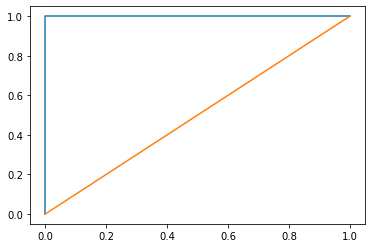

In [66]:
#Iris-setosa and Iris-virginica
print("Iris-setosa and Iris-virginica\n")
#read and load the data file
iris = pd.read_csv('iris.tmls')

#remove the first example line
iris = iris.iloc[1: , :]

#remove the Iris-virginica class
iris = iris.drop(iris.index[100:150])

#change the class variable from string to integer
iris["class"].replace({"Iris-setosa": 0, "Iris-versicolor": 1}, inplace=True)

iris = iris.values.tolist()

Y_test, Y_pred = k_fold_cv(iris, numfolds = 10)
roc_curve(Y_test, Y_pred)

Iris-versicolor and Iris-virginica

AUC: 1.0


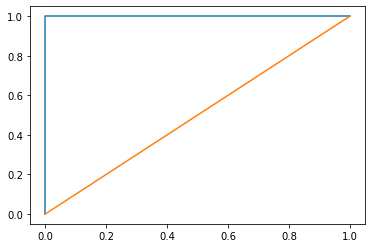

In [67]:
#Iris-versicolor and Iris-virginica
print("Iris-versicolor and Iris-virginica\n")

#read and load the data file
iris = pd.read_csv('iris.tmls')

#remove the first example line
iris = iris.iloc[1: , :]

#remove the Iris-setosa class
iris = iris.drop(iris.index[0:50])
#change the class variable from string to integer
iris["class"].replace({"Iris-versicolor": 0, "Iris-virginica": 1}, inplace=True)

iris = iris.values.tolist()

Y_test, Y_pred = k_fold_cv(iris, numfolds = 10)
roc_curve(Y_test, Y_pred)

Iris-setosa and Iris-virginica

AUC: 1.0


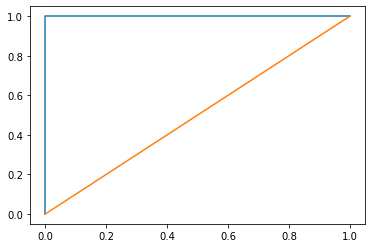

In [64]:
#Iris-setosa and Iris-virginica
print("Iris-setosa and Iris-virginica\n")

#read and load the data file
iris = pd.read_csv('iris.tmls')

#remove the first example line
iris = iris.iloc[1: , :]

#remove the Iris-versicolor class
iris = iris.drop(iris.index[50:100])
#change the class variable from string to integer
iris["class"].replace({"Iris-setosa": 0, "Iris-virginica": 1}, inplace=True)

iris = iris.values.tolist()

Y_test, Y_pred = k_fold_cv(iris, numfolds = 10)
roc_curve(Y_test, Y_pred)


